# San Diego software developer salaries

Here's the data from Glassdoor, a popular employer review site:

![glassdoor](https://github.com/aronasorman/salary-medianer/raw/master/glassdoor.png)

[Open above image in a new tab](https://github.com/aronasorman/salary-medianer/raw/master/glassdoor.png)

We also have used the H1B applications and the associated salary offerings found there:

![h1b](https://github.com/aronasorman/salary-medianer/raw/master/h1b-graph.png)
[Open above image in a new tab](https://github.com/aronasorman/salary-medianer/raw/master/h1b-graph.png)

For various software development jobs, FLE's standard salary of 70k is almost always below the the average, and for the H1B data specifically, it's in the bottom 20% of salaries for software engineers here in San Diego. 

## Plotting data from glassdoor.com

[Glassdoor](https://www.glassdoor.com/index.htm) is a popular employer review site, where current and previous employees can review various aspects of their employers, from culture to benefits. One other popular contribution is employee compensations.

Our goal here is to retrieve these employee compensation numbers from Glassdoor and then plot these numbers, relative to FLE's current flat salary.

The code for retrieving these numbers is shown below.

For now, let's import all the code necessary for that.

In [1]:
import pathlib
import requests
import pandas
import seaborn
import re
import numpy as np
from bokeh import mpl
from bokeh.plotting import figure, show, output_notebook

%matplotlib inline

output_notebook()

seaborn.set_style('whitegrid')

Loading BokehJS ...

Glassdoor's API doesn't work, so we simply scrape their pages.

Their salaries come in the form of ranges for each company, given in the form of `Est. Salary 80k-150k`. The code below looks for this text and extracts these numbers.

In [2]:
regex = re.compile('Est\. Salary \$(?P<low>\d+)k-\$(?P<high>\d+)k')


def download_salaries(url, page):
    r = requests.get(url.format(page=page),
                     headers={'User-Agent': 'Mozilla/5.0 (Windows NT x.y; rv:10.0) Gecko/20100101 Firefox/10.0'})
    r.raise_for_status()
    return regex.findall(r.content.decode('utf-8'))

I manually copied over the URLs for the following job titles. This should provide a good starting point and make our job easier. We download the first 10 pages of each job title search result.

In [3]:
urls = {
    "senior software engineer": "https://www.glassdoor.com/Job/la-jolla-senior-software-engineer-jobs-SRCH_IL.0,8_IC1147294_KO9,33_IP{page}.htm?lst=-1",
    "software engineer": "https://www.glassdoor.com/Job/la-jolla-software-engineer-jobs-SRCH_IL.0,8_IC1147294_KO9,26_IP{page}.htm?lst=-1",
    "junior software engineer": "https://www.glassdoor.com/Job/la-jolla-junior-software-engineer-jobs-SRCH_IL.0,8_IC1147294_KO9,33_IP{page}.htm?lst=-1",
    "python developer": "https://www.glassdoor.com/Job/la-jolla-python-developer-jobs-SRCH_IL.0,8_IC1147294_KO9,25_IP{page}.htm?lst=-1",
    "javascript developer": "https://www.glassdoor.com/Job/la-jolla-javascript-developer-jobs-SRCH_IL.0,8_IC1147294_KO9,29_IP{page}.htm?lst=-1",
    "devops engineer": "https://www.glassdoor.com/Job/la-jolla-devops-engineer-jobs-SRCH_IL.0,8_IC1147294_KO9,24_IP{page}.htm?lst=-1",
    "ux designer": "https://www.glassdoor.com/Job/la-jolla-ux-designer-jobs-SRCH_IL.0,8_IC1147294_KO9,20_IP{page}.htm?lst=-1",
}
max_pages = 10

Now, we go over each job title and put it into a dataset to graph. 

In [4]:
import itertools
from collections import OrderedDict

job_salary_range = []
for job, url in urls.items():
    salary_ranges = list(itertools.chain(*[download_salaries(url, page) for page in range(1, max_pages + 1)]))
    for salary in salary_ranges:
        row = OrderedDict([('job_title', job), ('salary_low_range', int(salary[0])),
                           ('salary_high_range', int(salary[1]))])
        job_salary_range.append(row)

job_salary_range = pandas.DataFrame(job_salary_range)
job_salary_range['salary_low_range'] = job_salary_range['salary_low_range'] * 1000
job_salary_range['salary_high_range'] = job_salary_range['salary_high_range'] * 1000
job_salary_range['mean_salary_range'] = (job_salary_range['salary_low_range'] + job_salary_range[
    'salary_high_range']) / 2
job_salary_range.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 4 columns):
job_title            1605 non-null object
salary_low_range     1605 non-null int64
salary_high_range    1605 non-null int64
mean_salary_range    1605 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 50.2+ KB


In [5]:
job_salary_range.head()

,job_title,salary_low_range,salary_high_range,mean_salary_range
0,senior software engineer,106000,142000,124000.0
1,senior software engineer,85000,116000,100500.0
2,senior software engineer,107000,136000,121500.0
3,senior software engineer,102000,137000,119500.0
4,senior software engineer,122000,150000,136000.0


We managed to get the data. What we have now is a row corresponding to a company and job title, and then the corresponding low-end of their salary, their high end, and then the median salary between the two numbers.

After that, we plot the median salaries for each job title.

/Users/aron/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


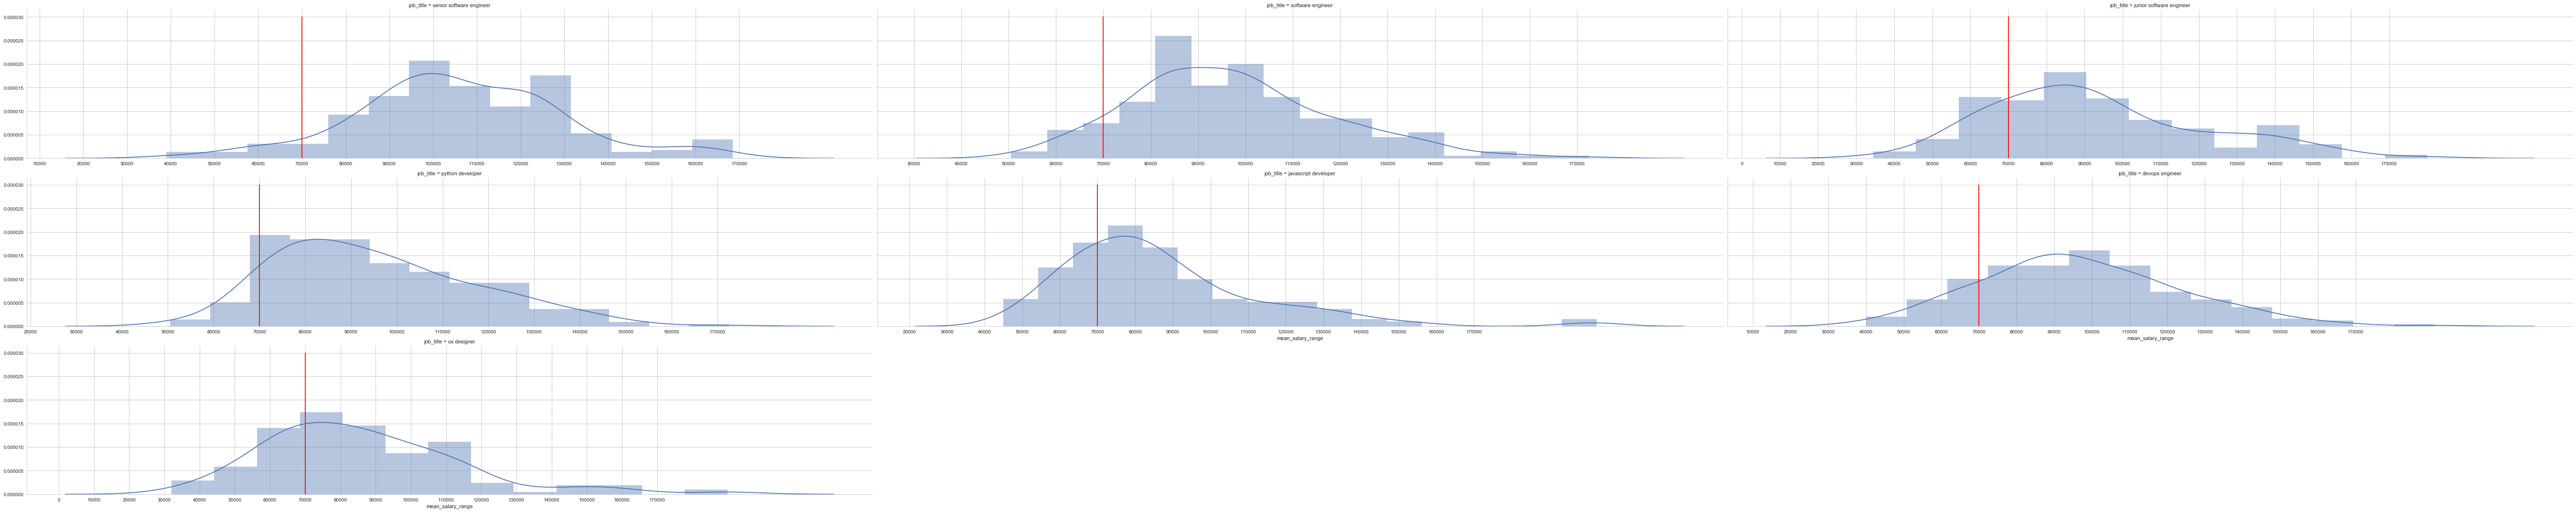

In [6]:
g = seaborn.FacetGrid(job_salary_range, col='job_title', col_wrap=3, aspect=5, size=5, sharex=False)
g.set(xticks=np.arange(0, 180000,10000))

import matplotlib.pyplot as plt

def fle_line_distplot(x, **kwargs):
    ax = plt.gca()
    ax = seaborn.distplot(x, ax=ax, **kwargs)
    ax.plot([70000, 70000],[0, .00003], 'r', linestyle='-')

my_mpl = plt.figure()
g = g.map(fle_line_distplot, 'mean_salary_range')

## Plotting H1B salaries

Another data source for salaries would be the H1B applications that are made available by the Bureau of Labor and Statistics. Companies applying for H1B visas are required to disclose the salary offers.

The data is available through an Excel file in the DOL's website. Let's retrieve that Excel file and load it for analysis.

The H1B data can be downloaded from the DOL website [here](https://www.foreignlaborcert.doleta.gov/docs/Performance_Data/Disclosure/FY15-FY16/H-1B_Disclosure_Data_FY16.xlsx).

The column descriptions can be found [here](https://www.foreignlaborcert.doleta.gov/docs/Performance_Data/Disclosure/FY15-FY16/H-1B_FY16_Record_Layout.pdf).

In [7]:
h1b_data_url = "https://www.foreignlaborcert.doleta.gov/docs/Performance_Data/Disclosure/FY15-FY16/H-1B_Disclosure_Data_FY16.xlsx"
h1b_data_download_path = pathlib.Path.cwd() / "h1b_data.xlsx"

if not h1b_data_download_path.exists():
    r = requests.get(h1b_data_url, stream=True)
    r.raise_for_status()

    with open(h1b_data_download_path, "w") as f:
        for chunk in r.iter_content(1024):
            f.write(chunk)

h1bdata = pandas.read_excel(h1b_data_download_path)
h1bdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647852 entries, 0 to 647851
Data columns (total 40 columns):
CASE_NUMBER              647852 non-null object
CASE_STATUS              647852 non-null object
CASE_SUBMITTED           647852 non-null datetime64[ns]
DECISION_DATE            647852 non-null datetime64[ns]
VISA_CLASS               647852 non-null object
EMPLOYMENT_START_DATE    647835 non-null datetime64[ns]
EMPLOYMENT_END_DATE      647827 non-null datetime64[ns]
EMPLOYER_NAME            647837 non-null object
EMPLOYER_ADDRESS         647847 non-null object
EMPLOYER_CITY            647846 non-null object
EMPLOYER_STATE           647818 non-null object
EMPLOYER_POSTAL_CODE     647831 non-null object
EMPLOYER_COUNTRY         647849 non-null object
EMPLOYER_PROVINCE        7672 non-null object
EMPLOYER_PHONE           647849 non-null object
EMPLOYER_PHONE_EXT       34262 non-null object
AGENT_ATTORNEY_NAME      647852 non-null object
AGENT_ATTORNEY_CITY      406318 non-null obj

That should load the H1B application data set from the DOL. The data includes both approved and rejected H1B applications. Let's filter for accepted applications, and then only get the ones that are here in San Diego.

In [8]:
h1ba = h1bdata[h1bdata['CASE_STATUS'] == 'CERTIFIED']
sd = h1ba[(h1ba['WORKSITE_STATE'] == 'CA') & (h1ba['WORKSITE_CITY'] == 'SAN DIEGO')]
len(sd)

3941

Let's now filter for entries that are related to software engineering.

In [10]:
# Get all titles that have "SOFTWARE" or "PROGRAMMER" in them
sdsw = sd[(sd['JOB_TITLE'].str.contains('SOFTWARE')) | (sd['JOB_TITLE'].str.contains('PROGRAMMER')) | (sd['WAGE_UNIT_OF_PAY'] == 'Year')]
sdsw.sample(50)

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_ADDRESS,EMPLOYER_CITY,...,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,WAGE_UNIT_OF_PAY,H-1B_DEPENDENT,WILLFUL_VIOLATOR,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_STATE,WORKSITE_POSTAL_CODE,ORIGINAL_CERT_DATE
405360,I-200-15294-647902,CERTIFIED,2015-10-21,2015-10-27,H-1B,2015-10-26,2018-10-26,BROADCOM CORPORATION,5300 CALIFORNIA AVENUE,IRVINE,...,122200.00,188500.00,Year,N,N,SAN DIEGO,SAN DIEGO,CA,92127,NaT
616504,I-200-16068-737583,CERTIFIED,2016-03-11,2016-03-17,H-1B,2016-09-07,2019-09-06,PASSION PLANNER LLC,9550 CHESAPEAKE DR,SAN DIEGO,...,41080.00,0.00,Year,N,N,SAN DIEGO,SAN DIEGO,CA,92123,NaT
264715,I-200-16116-264869,CERTIFIED,2016-04-25,2016-04-29,H-1B,2016-10-01,2019-09-30,IGATE TECHNOLOGIES INC.,200 SOMERSET CORPORATE BLVD,BRIDGEWATER,...,68000.00,0.00,Year,Y,N,SAN DIEGO,SAN DIEGO,CA,92121,NaT
551748,I-200-16061-034451,CERTIFIED,2016-03-02,2016-03-08,H-1B,2016-09-01,2019-08-31,"QUALCOMM TECHNOLOGIES, INC.",5775 MOREHOUSE DRIVE,SAN DIEGO,...,82618.00,97900.00,Year,Y,N,SAN DIEGO,SAN DIEGO,CA,92121,NaT
542897,I-200-15274-680021,CERTIFIED,2015-10-01,2015-10-07,H-1B,2016-03-22,2019-03-21,"QUALCOMM TECHNOLOGIES, INC.",5775 MOREHOUSE DRIVE,SAN DIEGO,...,111925.00,166700.00,Year,Y,N,SAN DIEGO,SAN DIEGO,CA,92121,NaT
502358,I-200-16187-749111,CERTIFIED,2016-07-05,2016-07-11,H-1B,2016-07-05,2019-07-04,CAPGEMINI AMERICA INC,623 FIFTH AVENUE,NEW YORK,...,72987.00,151000.00,Year,Y,N,SAN DIEGO,SAN DIEGO,CA,92123,NaT
619187,I-200-16089-364309,CERTIFIED,2016-03-29,2016-04-04,H-1B,2016-09-28,2019-09-28,EMERALD CITY ACADEMY OF RHYTHMIC GYMNASTICS,826 ORANGE AVENUE,CORONADO,...,30863.00,0.00,Year,N,N,SAN DIEGO,SAN DIEGO,CA,92131,NaT
448811,I-200-16187-489003,CERTIFIED,2016-07-05,2016-07-11,H-1B,2016-11-07,2019-11-06,QUALCOMM INCORPORATED,5775 MOREHOUSE DRIVE,SAN DIEGO,...,103875.00,150000.00,Year,Y,N,SAN DIEGO,SAN DIEGO,CA,92121,NaT
406410,I-200-15328-284353,CERTIFIED,2015-11-30,2015-12-04,H-1B,2015-12-08,2018-12-07,"SPIDERCLOUD WIRELESS, INC.",408 E. PLUMERIA DRIVE,SAN JOSE,...,115253.00,0.00,Year,Y,N,SAN DIEGO,SAN DIEGO,CA,92127,NaT
193919,I-200-16263-474148,CERTIFIED,2016-09-22,2016-09-28,H-1B,2016-09-28,2019-09-27,PRICEWATERHOUSECOOPERS ADVISORY SERVICES LLC,4040 WEST BOY SCOUT BLVD.,TAMPA,...,106000.00,0.00,Year,N,N,SAN DIEGO,SAN DIEGO,CA,92121,NaT


Looks like the use of the `WAGE_RATE_OF_PAY_FROM` and the `WAGE_RATE_OF_PAY_TO` appears to be inconsistent -- sometimes the FROM column is 0 with the TO column having a value, sometimes it's the FROM that has a value and the TO column has none. And sometimes they have both values. 

To fix this discrepancy in the general case, I created a new column called `WAGE_RATE_EST` that gets the max of both columns. That way we have a consistent number to use for plotting.

In [11]:
sdsw['WAGE_RATE_EST'] = sdsw[['WAGE_RATE_OF_PAY_FROM', 'WAGE_RATE_OF_PAY_TO']].max(axis=1).fillna(method='bfill')
len(sdsw)

/Users/aron/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


3791

Now that we have the data cleaned up, let's see where FLE's standard of 70k salary fits with the rest. Let's list out the deciles and then eyeball where our 70k salary sits at.

In [15]:
deciles = np.arange(0, 1., 0.05)
sdsw['WAGE_RATE_EST'].quantile(deciles)

0.00        25.05
0.05     57000.00
0.10     62000.00
0.15     68000.00
0.20     72946.00
0.25     75935.00
0.30     78354.00
0.35     83273.00
0.40     89271.84
0.45     94000.00
0.50    100000.00
0.55    105000.00
0.60    110000.00
0.65    116862.00
0.70    124400.00
0.75    128900.00
0.80    135000.00
0.85    145000.00
0.90    156700.00
0.95    167124.00
Name: WAGE_RATE_EST, dtype: float64

Looks like FLE's compensation for devs is in the bottom 20% of software devs in San Diego.

We're now almost ready to graph this. Next, let's remove outliers so we have a cleaner output.

In [12]:
# Let's remove outliers
low = 0.05
high = 0.95
q = sdsw['WAGE_RATE_EST'].quantile([low, high])
print(q)
sd_no_outliers = sdsw[(sdsw['WAGE_RATE_EST'] >= q.loc[low]) & (sdsw['WAGE_RATE_EST'] <= q.loc[high])]
len(sd_no_outliers)

0.05     57000.0
0.95    167124.0
Name: WAGE_RATE_EST, dtype: float64


3413

Let's see where FLE's current salary fits in the overall data.

/Users/aron/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


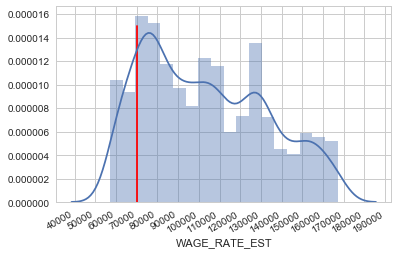

In [13]:
fig, ax = plt.subplots()
ax.set(xticks=np.arange(0, 500000,10000))
fig.autofmt_xdate()
ax.plot([70000, 70000],[0, .000015], 'r', linestyle='-')
seaborn.distplot(sd_no_outliers['WAGE_RATE_EST'])